In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Concatenate, Lambda

In [11]:
dataset = pd.read_csv("dataset/dataset.csv")
dataset = dataset.drop(columns=['date'])

In [12]:
dataset['volume'] = np.log1p(dataset['volume'])
scaler = StandardScaler()
scaled_columns = scaler.fit_transform(dataset[['high', 'low', 'open', 'close', 'volume']])
scaled_df = pd.DataFrame(scaled_columns, columns=['high', 'low', 'open', 'close', 'volume'])
min_max_scaler = MinMaxScaler()
scaled_columns_min_max = min_max_scaler.fit_transform(scaled_df[['high', 'low', 'open', 'close', 'volume']])
df = pd.DataFrame(scaled_columns_min_max, columns=['high', 'low', 'open', 'close', 'volume'])

In [13]:
def create_sequences(values, window_size):
    X, y = [], []
    for i in range(len(values) - window_size):
        X.append(values[i:(i + window_size)])
        y.append(values[i + window_size])
    return np.array(X), np.array(y)

window_size = 6 
X, y = create_sequences(df.values, window_size)


In [14]:
train_X, test_X = X[:-150], X[-150:]
train_y, test_y = y[:-150], y[-150:]

In [15]:
train_X.shape

(810, 6, 5)

In [16]:
train_data = tf.data.Dataset.from_tensor_slices((train_X, train_y))
train_data = train_data.batch(32).shuffle(buffer_size=1000)
test_data = tf.data.Dataset.from_tensor_slices((test_X, test_y))
test_data = test_data.batch(32)

# Elman

In [51]:
model = Sequential([
    Input(shape=(window_size, train_X.shape[2])),
    SimpleRNN(20, activation='relu'),
    Dense(train_y.shape[1])
])

In [52]:
model.compile(optimizer='adam', loss='mse')
history = model.fit(train_data, epochs=20, validation_data=test_data)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4893 - val_loss: 0.4389
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2187 - val_loss: 0.1634
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0504 - val_loss: 0.0198
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0042
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 6.3008e-04
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9919e-04 - val_loss: 4.8380e-04
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 4.1444e-04
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

In [53]:
loss = model.evaluate(test_data)
print(f'Test Loss: {loss}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4632e-04
Test Loss: 0.0002802900562528521


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


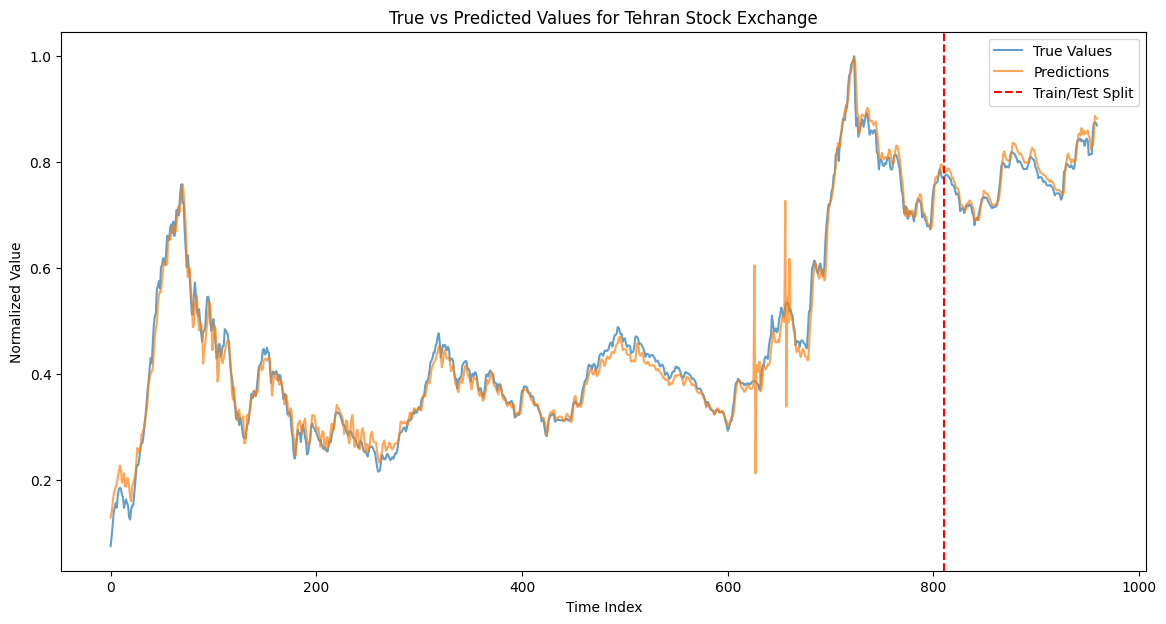

In [54]:
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)
true_values = np.concatenate((train_y, test_y), axis=0)
predictions = np.concatenate((train_predictions, test_predictions), axis=0)
plt.figure(figsize=(14, 7))
plt.plot(true_values[:, 0], label='True Values', alpha=0.7)
plt.plot(predictions[:, 0], label='Predictions', alpha=0.7)
plt.axvline(x=len(train_y), color='red', linestyle='--', label='Train/Test Split')
plt.title('True vs Predicted Values for Tehran Stock Exchange')
plt.xlabel('Time Index')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

# Jordan

In [68]:
input_shape = (window_size, train_X.shape[2])
output_units = train_y.shape[1]
main_input = Input(shape=input_shape, name='main_input')
prev_output_input = Input(shape=(output_units,), name='prev_output_input')
expanded_prev_output = Lambda(lambda x: tf.expand_dims(x, axis=1))(prev_output_input)
concatenated = Concatenate(axis=1)([expanded_prev_output, main_input])
rnn = SimpleRNN(100, activation='relu')(concatenated)
output = Dense(output_units, activation='linear')(rnn)
model = Model(inputs=[main_input, prev_output_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

In [69]:
initial_prev_output = np.zeros((train_X.shape[0], output_units))
history = model.fit([train_X, initial_prev_output], train_y, epochs=20, validation_split=0.2)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1166 - val_loss: 0.0820
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0248
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 0.0135
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1345e-04 - val_loss: 0.0077
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.3755e-04 - val_loss: 0.0069
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3513e-04 - val_loss: 0.0061
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8056e-04 - val_loss: 0.0052
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0556e-04 - val_loss: 0.0056
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3172e-04 - val_loss: 0.0050
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8656e-04 - val_loss: 0.0053
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 0.0054
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms

In [72]:
test_loss = model.evaluate([test_X, initial_prev_output_test], test_y)
print(f'Test MSE: {test_loss}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015     
Test MSE: 0.001958714099600911


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


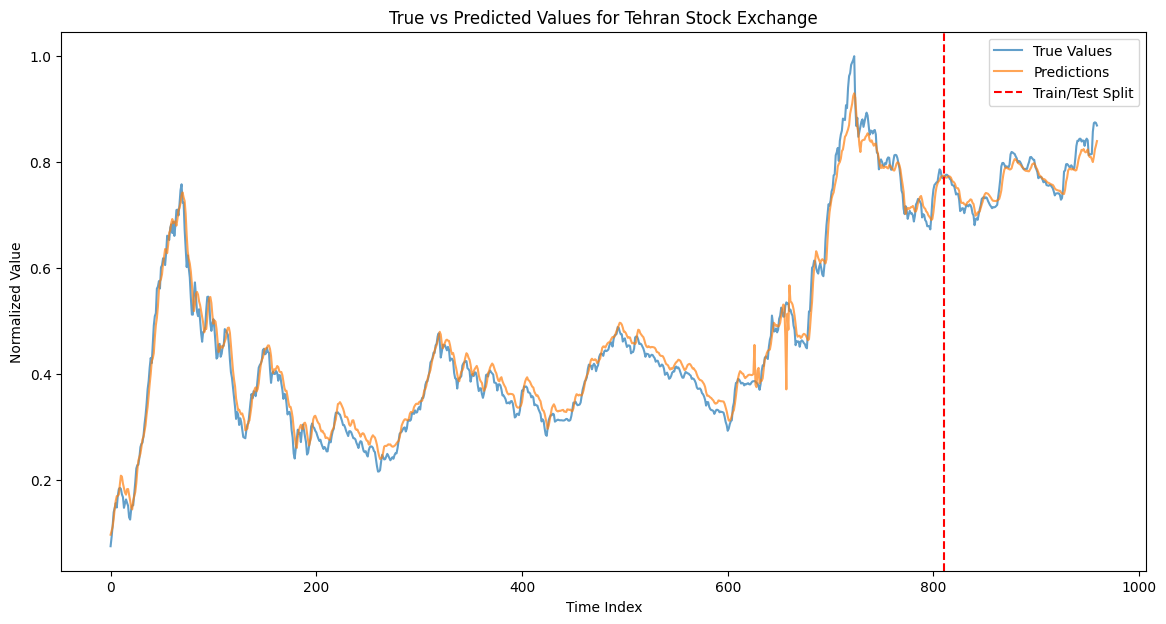

In [66]:
initial_prev_output_test = np.zeros((test_X.shape[0], output_units))
train_predictions = model.predict([train_X, initial_prev_output])
test_predictions = model.predict([test_X, initial_prev_output_test])
true_values = np.concatenate((train_y, test_y), axis=0)
predictions = np.concatenate((train_predictions, test_predictions), axis=0)
plt.figure(figsize=(14, 7))
plt.plot(true_values[:, 0], label='True Values', alpha=0.7)
plt.plot(predictions[:, 0], label='Predictions', alpha=0.7)
plt.axvline(x=len(train_y), color='red', linestyle='--', label='Train/Test Split')
plt.title('True vs Predicted Values for Tehran Stock Exchange')
plt.xlabel('Time Index')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()